In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib.pyplot as plt



num_of_clusters = 11

ToolName = 'scanpy' 
DatasetName = 'peripheal-blood'
Data_path = '../dataset/{}-filtered/10X/'.format(DatasetName)
save_path = '../results/{}/{}/'.format(DatasetName, ToolName)

if not os.path.exists(save_path):
    os.makedirs(save_path)


# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [2]:
adata = sc.read_10x_mtx(
    Data_path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False
)

/var/folders/13/j6b4qnl1339416k0hpyswb8r0000gn/T/ipykernel_14526/521235833.py:6: RuntimeWarning: divide by zero encountered in log
  sorted_array = [np.log(-i) for i in variances.T][:2000]


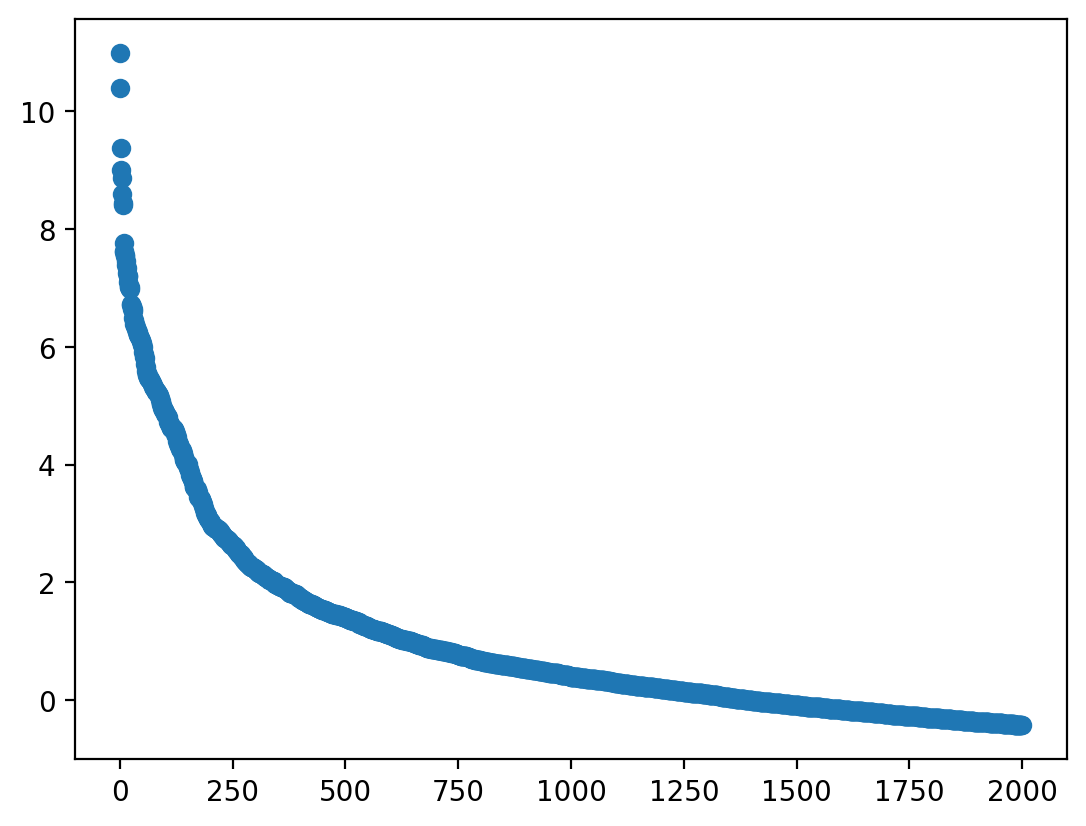

In [3]:
matrix = adata.X
# from sparse matrix to dense matrix
matrix = matrix.todense()
# find the most variable features (columns) of the matrix sorted by variance
variances = np.sort(-np.var(matrix, axis=0))
sorted_array = [np.log(-i) for i in variances.T][:2000]
# plot the variance of the features
plt.scatter([i for i in range(len(sorted_array))], sorted_array)

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3') # seurat FindVariableFeatures

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


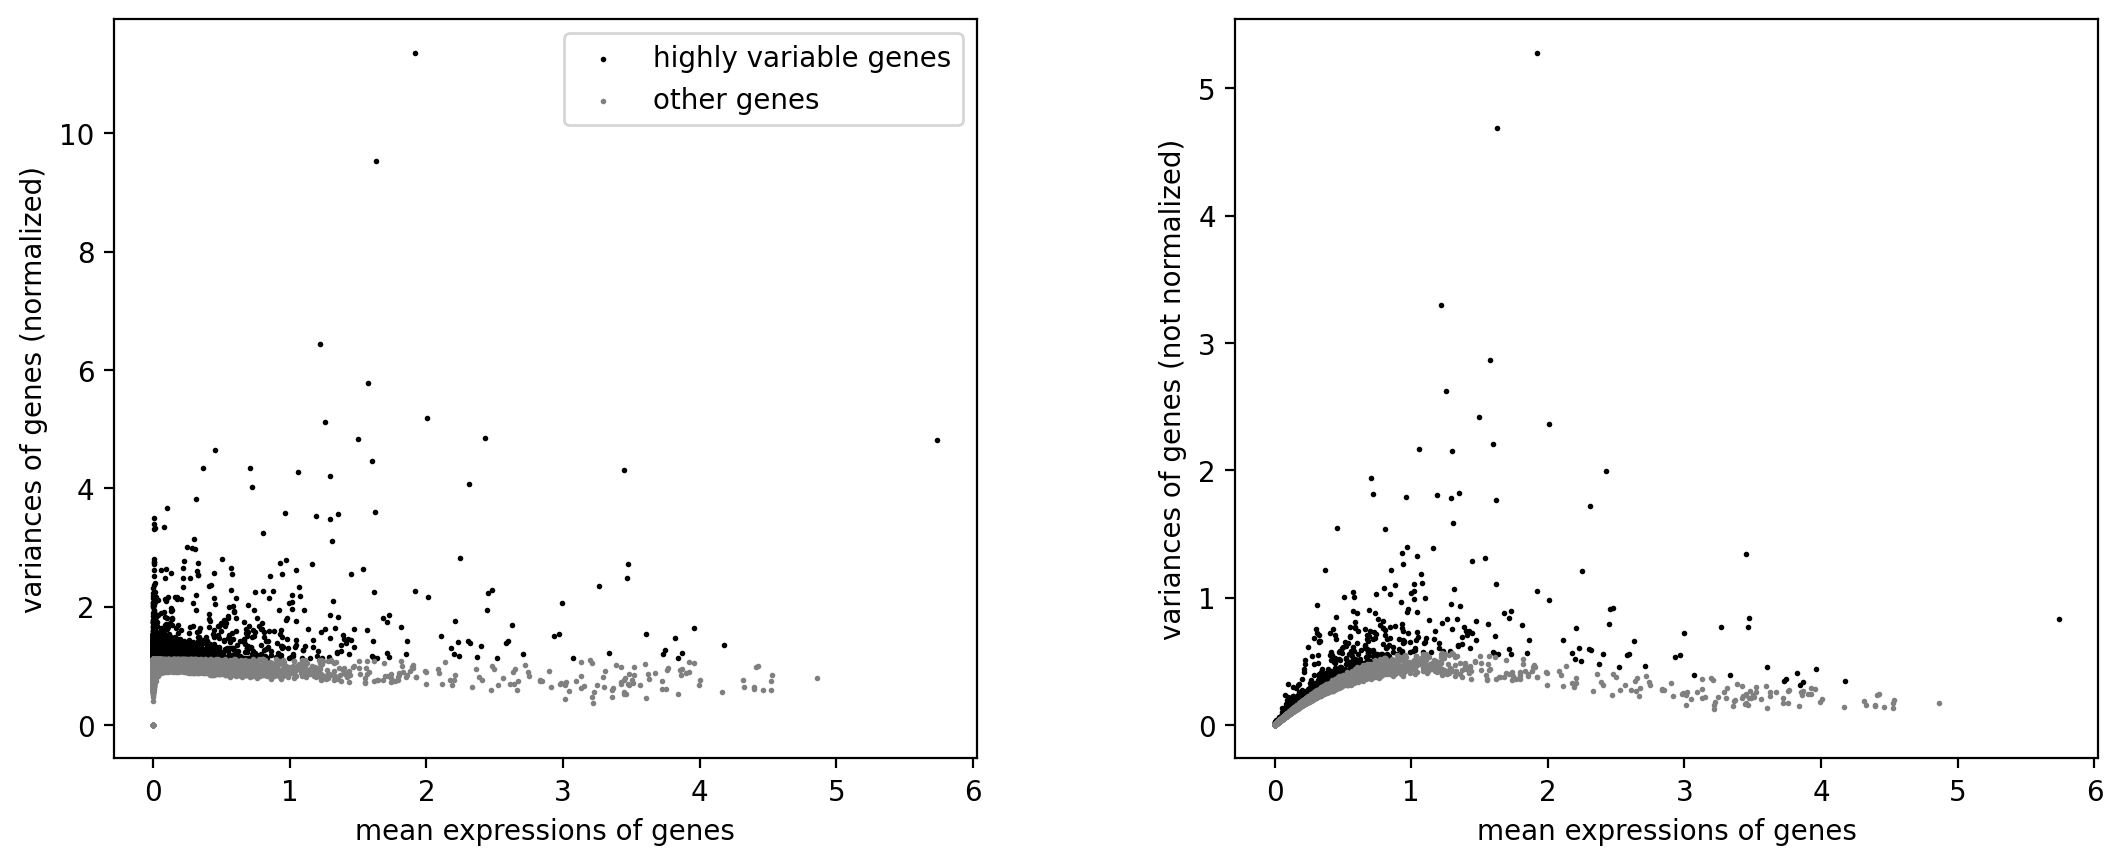

In [6]:
sc.pl.highly_variable_genes(adata)

In [7]:
sc.pp.scale(adata, max_value=10)

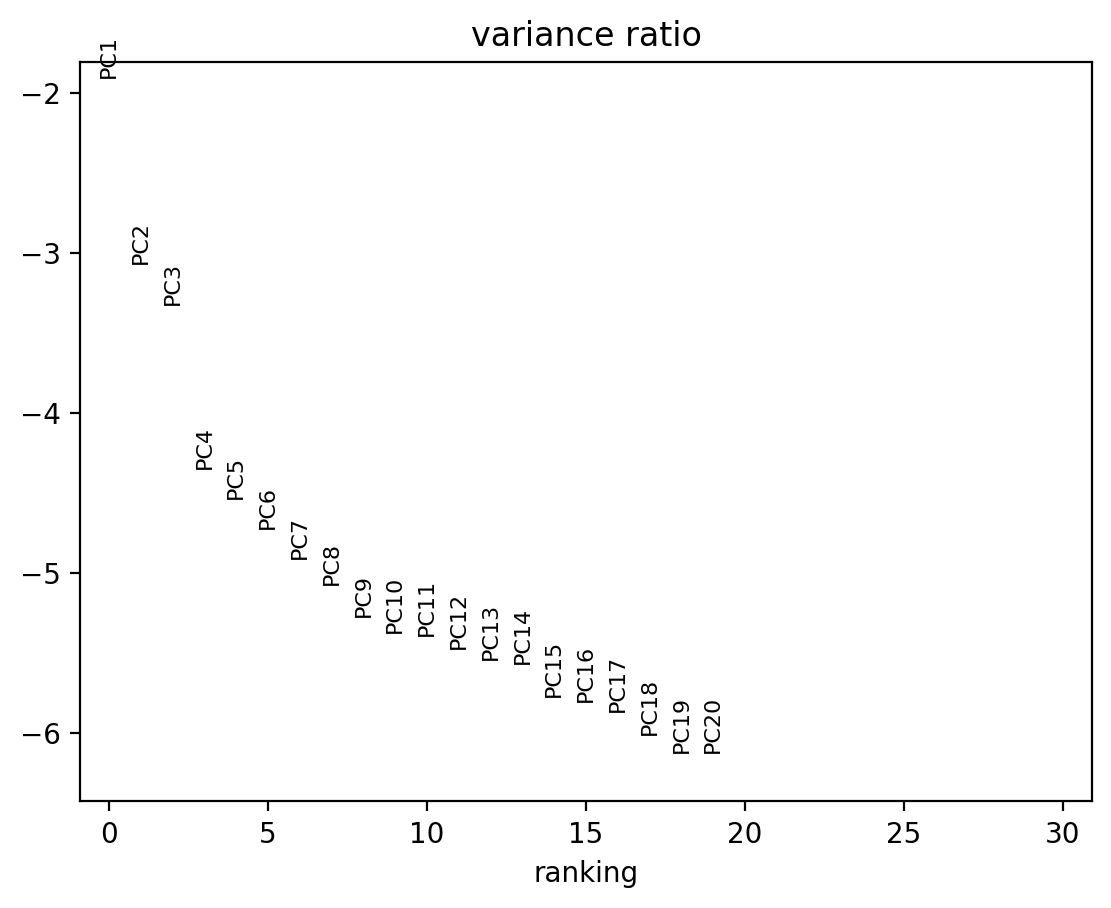

In [8]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=20, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

Iteration: 0, resolution: 3.5, clusters: (36,)
Iteration: 0, resolution: 3.501, clusters: (36,)
Iteration: 0, resolution: 3.502, clusters: (36,)
Iteration: 0, resolution: 3.5029999999999997, clusters: (36,)
Iteration: 0, resolution: 3.5039999999999996, clusters: (36,)
Iteration: 0, resolution: 3.5049999999999994, clusters: (36,)
Iteration: 0, resolution: 3.5059999999999993, clusters: (36,)
Iteration: 0, resolution: 3.5069999999999992, clusters: (36,)
Iteration: 0, resolution: 3.507999999999999, clusters: (36,)
Iteration: 0, resolution: 3.508999999999999, clusters: (36,)
Iteration: 0, resolution: 3.509999999999999, clusters: (36,)
Iteration: 0, resolution: 3.510999999999999, clusters: (36,)
Iteration: 0, resolution: 3.5119999999999987, clusters: (36,)
Iteration: 0, resolution: 3.5129999999999986, clusters: (36,)
Iteration: 0, resolution: 3.5139999999999985, clusters: (36,)
Iteration: 0, resolution: 3.5149999999999983, clusters: (36,)
Iteration: 0, resolution: 3.5159999999999982, cluster

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


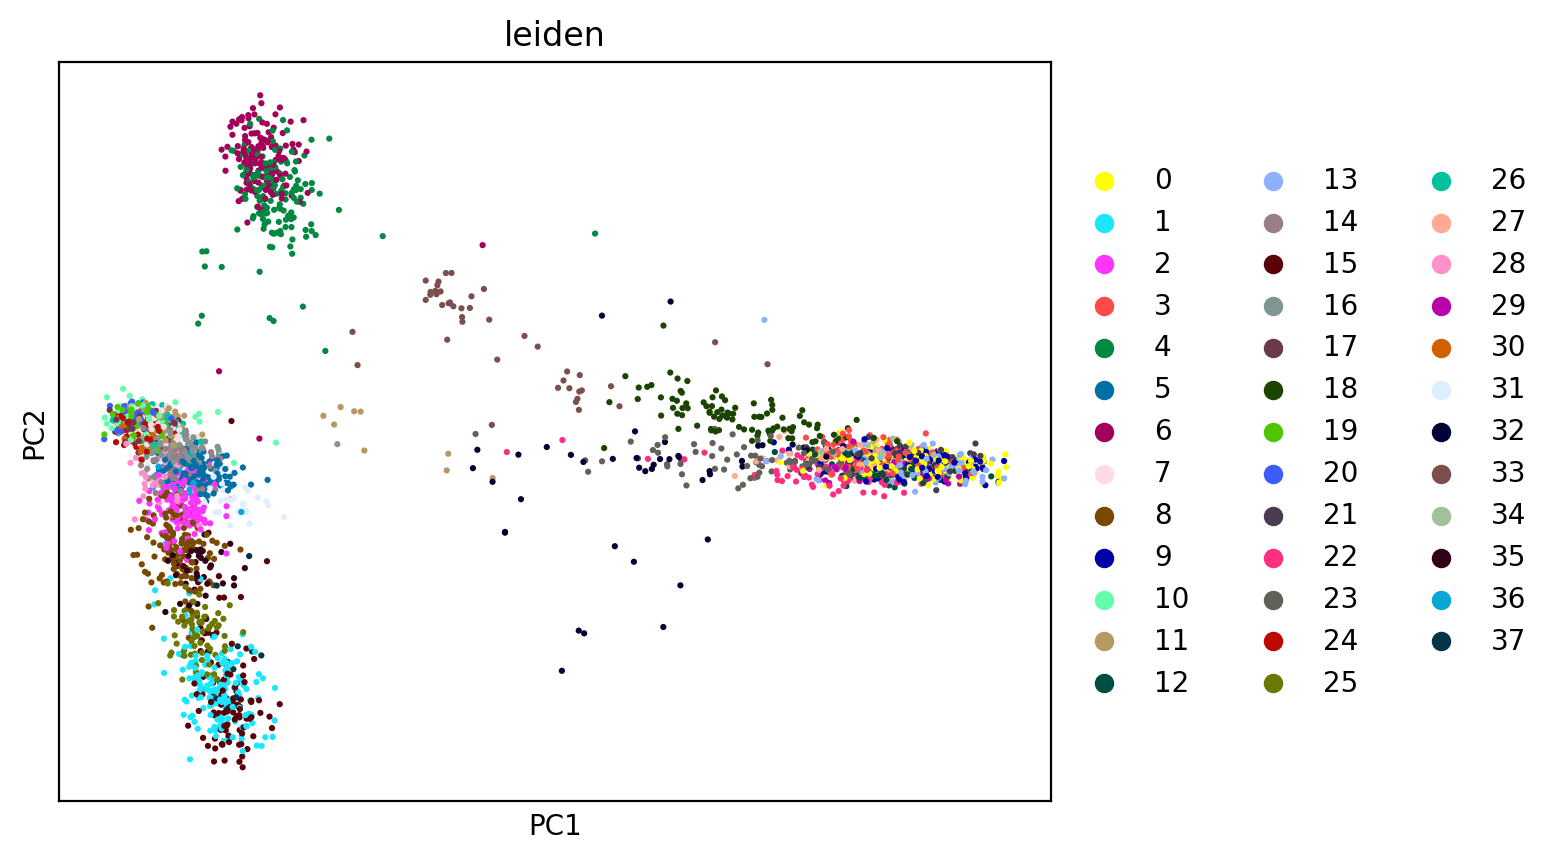

In [12]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)    # 15 è il default di scanpy

res = 3.500
it = 0
sc.tl.leiden(adata, resolution=res)
while not (adata.obs.leiden.values.categories.values).shape == (num_of_clusters, ) or res == 1.0:
    if it%50 == 0:
        print('Iteration: {}, resolution: {}, clusters: {}'.format(it, res, (adata.obs.leiden.values.categories.values).shape))
    res += 0.001
    sc.tl.leiden(adata, resolution=res)
    
sc.pl.pca(adata, color=['leiden'], size=20)

In [13]:
# cluster id for each cell renamed as cluster

df = pd.DataFrame(adata.obs['leiden'])

labels = df.rename(columns={'leiden': 'cluster'})
labels.index.name = 'cell'

labels['cluster'] = labels['cluster'].astype(int) + 1

labels.to_csv(f'{save_path}/clustering_labels.csv', index=True)

In [14]:
# silouhette score
#matrix = adata.X
#
#from sklearn.metrics import silhouette_score
#score = silhouette_score(matrix, labels, metric='euclidean')
#
## dataset with silouette score
#
#df = pd.DataFrame([score], columns=['silhouette'])
#df.to_csv(f'{save_path}/clustering_scores.csv', index=False)

In [15]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') 

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in

In [16]:
number_of_genes = 50

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(num_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)


df['cluster'] = df['cluster'].astype(int) + 1
df['rank'] = df['rank'].astype(int) + 1

df.to_csv(f'{save_path}/markers.csv', index=False)